# CNRS Applications study
---

In [75]:
import pandas as pd
import seaborn as sns

In [76]:
pd_candidates = pd.read_csv('7-22-51-55-less-dirty.csv')

In [77]:
# pd_candidates = pd_candidates[~pd_candidates['multiple results']]

In [81]:
pd_candidates = pd_candidates[2000<pd_candidates['First publication']]

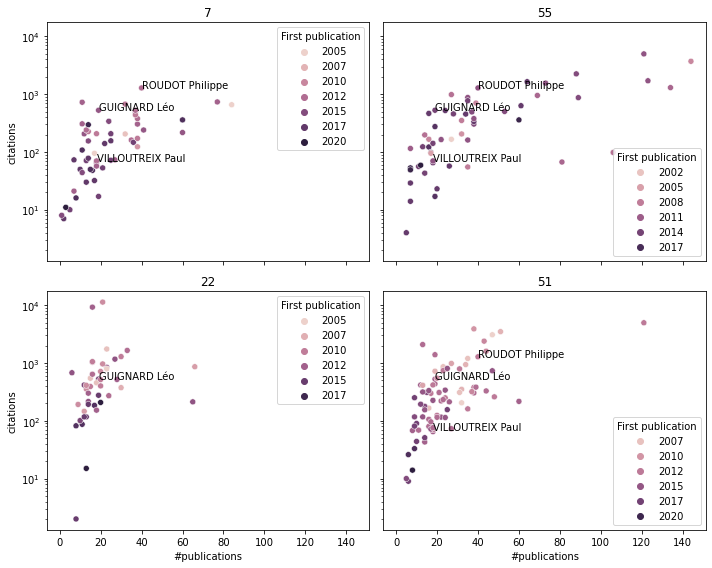

In [124]:
import matplotlib.pyplot as plt
to_look = ['ROUDOT Philippe', 'VILLOUTREIX Paul', 'GUIGNARD Léo']
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()
[ax.set(yscale='log') for ax in axes]
for ax, section in zip(axes, ['7', '55', '22', '51']):
    tmp = pd_candidates[pd_candidates[section]]
    sns.scatterplot(ax=ax, data=tmp, x='#publications', hue='First publication', y='citations')
    ax.set_title(section)
    for n in to_look:
        if n in pd_candidates[pd_candidates[section]]['name'].to_list():
            x = pd_candidates[pd_candidates['name']==n]['#publications']
            y = pd_candidates[pd_candidates['name']==n]['citations']
            ax.text(x, y, n)
fig.tight_layout()
fig.savefig('publication_plot.png')

['BARGIOTAS Ioannis',
 'BATMAZ Anil Ufuk',
 'GOLDIN Matias',
 'GUIGNARD Léo',
 'HERICE Charlotte',
 'HOURLIER Adrien',
 'RABIER Charles Elie',
 'ROUDOT Philippe',
 'TATTINI Lorenzo',
 'THOMINE Olivier',
 'THORET Etienne',
 'VACHER Jonathan',
 'VILLOUTREIX Paul',
 'COSGROVE Jason',
 'ILKER Efe',
 'RIBA Andrea',
 'SINIGAGLIA Chiara',
 'AMBROISE Matthieu',
 'BALABANOV Oleg',
 'BANSEPT Florence',
 'BARRAT-CHARLAIX Pierre',
 'BARTOCCI Alessio',
 'BASTIEN Renaud',
 'BEGEL Valentin',
 'BELKAID Marwen',
 'BERTHIER Estelle',
 'CHALOPIN-FILLOT Domitille',
 'CHENOUARD Nicolas',
 'CHEPIZHKO Oleksandr',
 'CHIMIENTI Marianna',
 'COREY Robin',
 'COSTE Christophe',
 'DEMORY David',
 'DI VOLO Matteo',
 'DIPOPPA Mario',
 'DUCLUT Charlie',
 'EL KAOUTARI Abdessamad',
 'ERLICH Alexander',
 'ERNY Xavier',
 'FACCHINI Giulio',
 'FERNANDEZ-DE-COSSIO-DIAZ Jorge',
 'FOSSAT Martin',
 'FOUGERON Nolwenn',
 'GALVAO FERRARINI Mariana',
 'GOMEZ-NAVA Luis',
 'GUIXA-GONZALEZ Ramon',
 'HADDACHE Mohamed',
 'HOZE Nathanael